# Reinforcement Learning with Novelty seeking for modeling human behavior

In [1]:
import gym
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
np.__version__

'1.26.4'

In [3]:
gym.__version__

'0.25.2'

In [4]:
# Гиперпараметры
ALPHA = 0.1  # Скорость обучения
GAMMA = 0.9  # Коэффициент дисконтирования
EPSILON = 0.1  # Эпсилон для ε-жадной стратегии
NOVELTY_WEIGHT = 0.5  # Вес новизны
DISCRETE_BINS = (20, 20)  # Количество разбиений (дискретизация) для состояния
EPISODES = 5000  # Количество эпизодов для обучения

# Создаем среду
env = gym.make("MountainCar-v0")

# Функция дискретизации непрерывных состояний
def discretize_state(state, env_low, env_high, bins=DISCRETE_BINS):
    ratios = (state - env_low) / (env_high - env_low)
    discrete_state = (ratios * np.array(bins)).astype(int)
    return tuple(np.clip(discrete_state, 0, np.array(bins) - 1))

# Инициализация Q-таблицы
state_space_bins = DISCRETE_BINS
action_space = env.action_space.n
Q_table = np.zeros(state_space_bins + (action_space,))

# Таблица для учета количества посещений (новизна)
state_visits = defaultdict(int)

# Функция выбора действия с учетом ε-жадного подхода и компонента новизны
def choose_action(state):
    if random.uniform(0, 1) < EPSILON:
        return env.action_space.sample()  # Выбираем случайное действие
    else:
        novelty_bonus = np.array(
            [NOVELTY_WEIGHT / (1 + state_visits[state + (a,)]) for a in range(action_space)]
        )
        q_values_with_novelty = Q_table[state] + novelty_bonus
        return np.argmax(q_values_with_novelty)  # Выбираем действие с наилучшей скорректированной ценностью

# Основной цикл обучения
for episode in range(EPISODES):
    # Сбрасываем среду
    state_raw, _ = env.reset()

    state = discretize_state(state_raw, env.observation_space.low, env.observation_space.high)
    total_reward = 0
    done = False
    step = 0

    while not done:
        step += 1
        # Выбор действия
        action = choose_action(state)

        # Выполняем действие и переходим в новое состояние
        next_state_raw, reward, done, _ = env.step(action)

        next_state = discretize_state(next_state_raw, env.observation_space.low, env.observation_space.high)

        # Награда модифицируется для поощрения поиска новизны
        if done and next_state_raw[0] >= env.goal_position:  # Если цель достигнута
            reward = 1
        else:
            reward -= 0.1  # Небольшое наказание за каждый шаг для улучшения обучения

        # Обновляем таблицу посещений
        state_visits[state + (action,)] += 1

        # Обновляем Q-значения
        old_value = Q_table[state + (action,)]
        next_max = np.max(Q_table[next_state])
        Q_table[state + (action,)] = old_value + ALPHA * (reward + GAMMA * next_max - old_value)

        # Переходим в новое состояние
        state = next_state
        total_reward += reward

        if done:
            break

    if episode % 100 == 0:
        print(f"Episode: {episode}, Reward: {total_reward}, Steps: {step}")

# Закрытие среды
env.close()

# Демонстрация количества посещений состояний
print("\n=== State-Action Visits ===")
for key, value in list(state_visits.items())[:10]:  # Показываем первые 10 записей
    print(f"State-Action: {key}, Visits: {value}")


Episode: 0, Reward: -219.99999999999926, Steps: 200
Episode: 100, Reward: -219.99999999999926, Steps: 200
Episode: 200, Reward: -219.99999999999926, Steps: 200
Episode: 300, Reward: -219.99999999999926, Steps: 200
Episode: 400, Reward: -219.99999999999926, Steps: 200
Episode: 500, Reward: -219.99999999999926, Steps: 200
Episode: 600, Reward: -219.99999999999926, Steps: 200
Episode: 700, Reward: -219.99999999999926, Steps: 200
Episode: 800, Reward: -184.89999999999944, Steps: 170
Episode: 900, Reward: -219.99999999999926, Steps: 200
Episode: 1000, Reward: -219.99999999999926, Steps: 200
Episode: 1100, Reward: -219.99999999999926, Steps: 200
Episode: 1200, Reward: -179.39999999999947, Steps: 165
Episode: 1300, Reward: -206.89999999999932, Steps: 190
Episode: 1400, Reward: -219.99999999999926, Steps: 200
Episode: 1500, Reward: -219.99999999999926, Steps: 200
Episode: 1600, Reward: -219.99999999999926, Steps: 200
Episode: 1700, Reward: -219.99999999999926, Steps: 200
Episode: 1800, Reward:

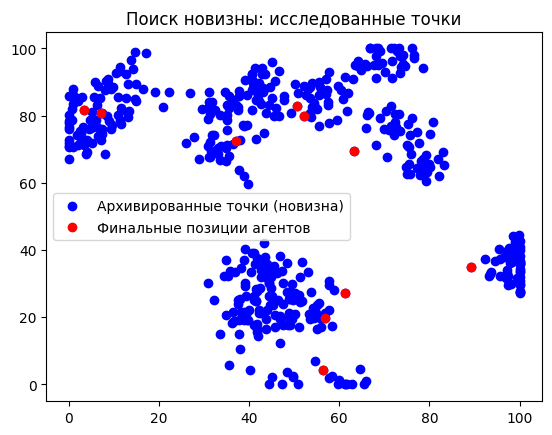

In [9]:
# Определение области поиска
SPACE_SIZE = 100  # Размер пространства
NUM_AGENTS = 10  # Количество агентов
STEPS = 50  # Количество шагов для обучения
NOVELTY_THRESHOLD = 5  # Минимальная "новизна" для вознаграждения

# Функция для расчета расстояния между двумя точками
def distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

# Функция для расчета "новизны" точки (на основе расстояния до прошлых состояний)
def calculate_novelty(position, archive):
    distances = [distance(position, past_position) for past_position in archive]
    if len(distances) == 0:
        return float('inf')  # Если архив пустой, это всегда новая точка
    return np.mean(distances)  # Новизна — среднее расстояние до всех пройденных точек

# Инициализация агентов и архива
agents = [np.random.uniform(0, SPACE_SIZE, size=(2,)) for _ in range(NUM_AGENTS)]
archive = []  # Архив для хранения уже посещенных точек

# Основной цикл обучения
for step in range(STEPS):

    # Для каждого агента: переместиться и оценить новизну
    for i, agent in enumerate(agents):
        # Генерация случайного перемещения агента
        move = np.random.uniform(-5, 5, size=(2,))
        new_position = np.clip(agent + move, 0, SPACE_SIZE)  # Убедимся, что остаемся в пределах пространства

        # Оценка новизны нового положения
        novelty = calculate_novelty(new_position, archive)

        # Если точка достаточно новая, сохраняем её в архив
        if novelty > NOVELTY_THRESHOLD:
            archive.append(new_position)

        # Обновляем положение агента
        agents[i] = new_position

# Визуализация
archive = np.array(archive)
agents = np.array(agents)
plt.scatter(archive[:, 0], archive[:, 1], c="blue", label="Архивированные точки (новизна)")
plt.scatter(agents[:, 0], agents[:, 1], c="red", label="Финальные позиции агентов")
plt.title("Поиск новизны: исследованные точки")
plt.legend()
plt.show()
